Download dataset

In [15]:
DATA_DIR = './data/img_align_celeba/'

from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset

from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
  zipObj.extractall('./data/')

Saving kaggle.json to kaggle.json
100% 1.32G/1.33G [00:14<00:00, 185MB/s]
100% 1.33G/1.33G [00:14<00:00, 99.7MB/s]


Imports ...

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras

Mount GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 128

In [16]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("./data/img_align_celeba/img_align_celeba",
                                                              label_mode=None,
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE)
dataset

Found 202599 files belonging to 1 classes.


<_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [ ]:
plt.figure(figsize=(10,10))
for img in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
normalization = layers.experimental.preprocessing.Rescaling(scale = 1./255)
norm_dataset = dataset.map(lambda x: normalization(x))

In [3]:
INPUT_DIM = (128, 128, 3)
LATENT_DIM = (200,)

In [4]:
def generate_samples(distribution_params):
  mean, log_variance = distribution_params
  epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
  return mean + K.exp(log_variance / 2) * epsilon

In [5]:
def sampling(latent_dim):
  mean = keras.Input(shape=latent_dim, name='input_mean')
  log_variance = keras.Input(shape=latent_dim, name='input_log_variance')
  out = layers.Lambda(generate_samples, name='enc_out_lambda')([mean, log_variance])
  enc_sampler = tf.keras.Model([mean, log_variance], out, name='encoder_sampler')
  return enc_sampler

In [6]:
def build_encoder(input_dim, latent_dim):
  encoder_input = keras.Input(shape=input_dim, name='enc_input')

  # 1
  x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', name='enc_conv_1')(encoder_input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # 2
  x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='enc_conv_2')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # 3
  x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='enc_conv_3')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # 4
  x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='enc_conv_4')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # 5
  x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='enc_conv_5')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # Final
  flatten = layers.Flatten()(x)
  mean = layers.Dense(latent_dim, name='mean')(flatten)
  log_variance = layers.Dense(latent_dim, name='log_variance')(flatten)

  model = tf.keras.Model(encoder_input, (mean, log_variance), name='encoder')
  return model

In [7]:
encoder = build_encoder(INPUT_DIM, LATENT_DIM[0])

In [8]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 enc_conv_1 (Conv2D)            (None, 64, 64, 32)   896         ['enc_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['enc_conv_1[0][0]']             
 alization)                                                                                       
                                                                                            

In [9]:
dec_input = sampling(LATENT_DIM)

In [10]:
def build_decoder(latent_dim):
  decoder_input = keras.Input(shape=latent_dim, name='dec_input')
  x = layers.Dense(1024, name='dense_1')(decoder_input)
  x = layers.Reshape((4,4,64), name='reshape')(x)

  # 1
  x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='dec_conv_1')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # 2
  x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='dec_conv_2')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # 3
  x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='dec_conv_3')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # 4
  x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', name='dec_conv_4')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # 5
  output = layers.Conv2DTranspose(3, 3, 2, padding='same', activation='sigmoid', name='dec_conv_5')(x)
  model = tf.keras.Model(decoder_input, output, name='decoder')
  return model

In [11]:
decoder = build_decoder(LATENT_DIM)

In [12]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dec_input (InputLayer)      [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              205824    
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 dec_conv_1 (Conv2DTranspose  (None, 8, 8, 64)         36928     
 )                                                               
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 64)          0   

In [14]:
LEARNING_RATE = 0.0005
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)

Losses

In [15]:
def mse_loss(y_true, y_pred):
  reconstruction_loss = K.mean(K.square(y_true - y_pred), axis=[1,2,3])
  return 1000 * reconstruction_loss

def kl_loss(mean, log_variance):
  kl_loss = -0.5 * K.sum(1 + log_variance - K.square(mean) - K.exp(log_variance), axis=1)
  return kl_loss

def total_loss(y_true, y_pred, mean, log_variance):
  r_loss = mse_loss(y_true, y_pred)
  kl = kl_loss(mean, log_variance)
  return r_loss + kl

Execute if not first training or don't want to train

In [13]:
encoder.load_weights("/content/drive/MyDrive/vae/encoder_weights.h5")
decoder.load_weights("/content/drive/MyDrive/vae/decoder_weights.h5")

In [21]:
from tensorflow.python import training
@tf.function
def train_step(images):
  with tf.GradientTape() as encoder_gt, tf.GradientTape() as decoder_gt:
    mean, log_variance = encoder(images, training=True)
    latent_vector = dec_input([mean, log_variance])
    generated_images = decoder(latent_vector, training=True)
    loss = total_loss(images, generated_images, mean, log_variance)

  enc_gradients = encoder_gt.gradient(loss, encoder.trainable_variables)
  dec_gradients = decoder_gt.gradient(loss, decoder.trainable_variables)

  optimizer.apply_gradients(zip(enc_gradients, encoder.trainable_variables))
  optimizer.apply_gradients(zip(dec_gradients, decoder.trainable_variables))

  return loss

In [22]:
os.makedirs("/content/drive/MyDrive/vae/weights", exist_ok=True)
os.makedirs("/content/drive/MyDrive/vae/images", exist_ok=True)

In [27]:
def generate_images(model, epoch, test_input):
  mean, log_variance = encoder(test_input, training=False)
  latent_vector = dec_input([mean, log_variance])
  predictions = decoder(latent_vector, training=False)
  print(predictions.shape)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(5, 5, i+1)
    pred = predictions[i, :, :, :] * 255
    pred = np.array(pred)
    pred = pred.astype(np.uint8)

    plt.imshow(pred)
    plt.axis('off')

  plt.savefig("/content/drive/MyDrive/vae/images/img_{:d}.png".format(epoch))
  plt.show()

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print("Epoсh" + str(epoch + 1))
    i = 0
    loss_ = []

    for image_batch in dataset:
      i += 1
      loss = train_step(image_batch)
      loss_.append(loss)

    seed = image_batch[:25]
    generate_images([encoder, dec_input, decoder],
                    epoch + 1,
                    seed)
    encoder.save_weights("/content/drive/MyDrive/vae/weights/enc_" + str(epoch) + '.h5')
    decoder.save_weights("/content/drive/MyDrive/vae/weights/dec_" + str(epoch) + ".h5")

  generate_images([encoder, dec_input, decoder],
                  epochs,
                  seed)

In [ ]:
EPOCHS = 50
train(norm_dataset, EPOCHS)

Generate new images

1/1 [==============================] - 0s 20ms/step


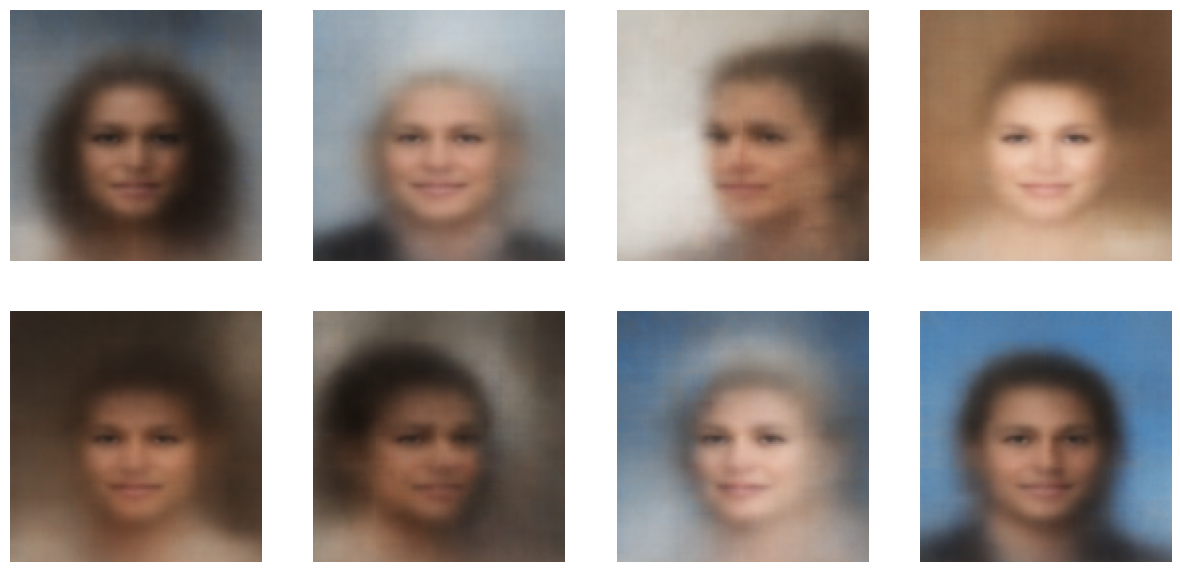

In [16]:
figsize = 15
x = np.random.normal(size=(8, 200))
generated = decoder.predict(x)

fig = plt.figure(figsize=(figsize, figsize))
for i in range(8):
  ax = fig.add_subplot(4,4,i+1)
  ax.axis('off')
  pred = generated[i, :, :, :] * 255
  pred = np.array(pred)
  pred = pred.astype(np.uint8)
  ax.imshow(pred)

Latent space distribution

4/4 [==============================] - 0s 3ms/step


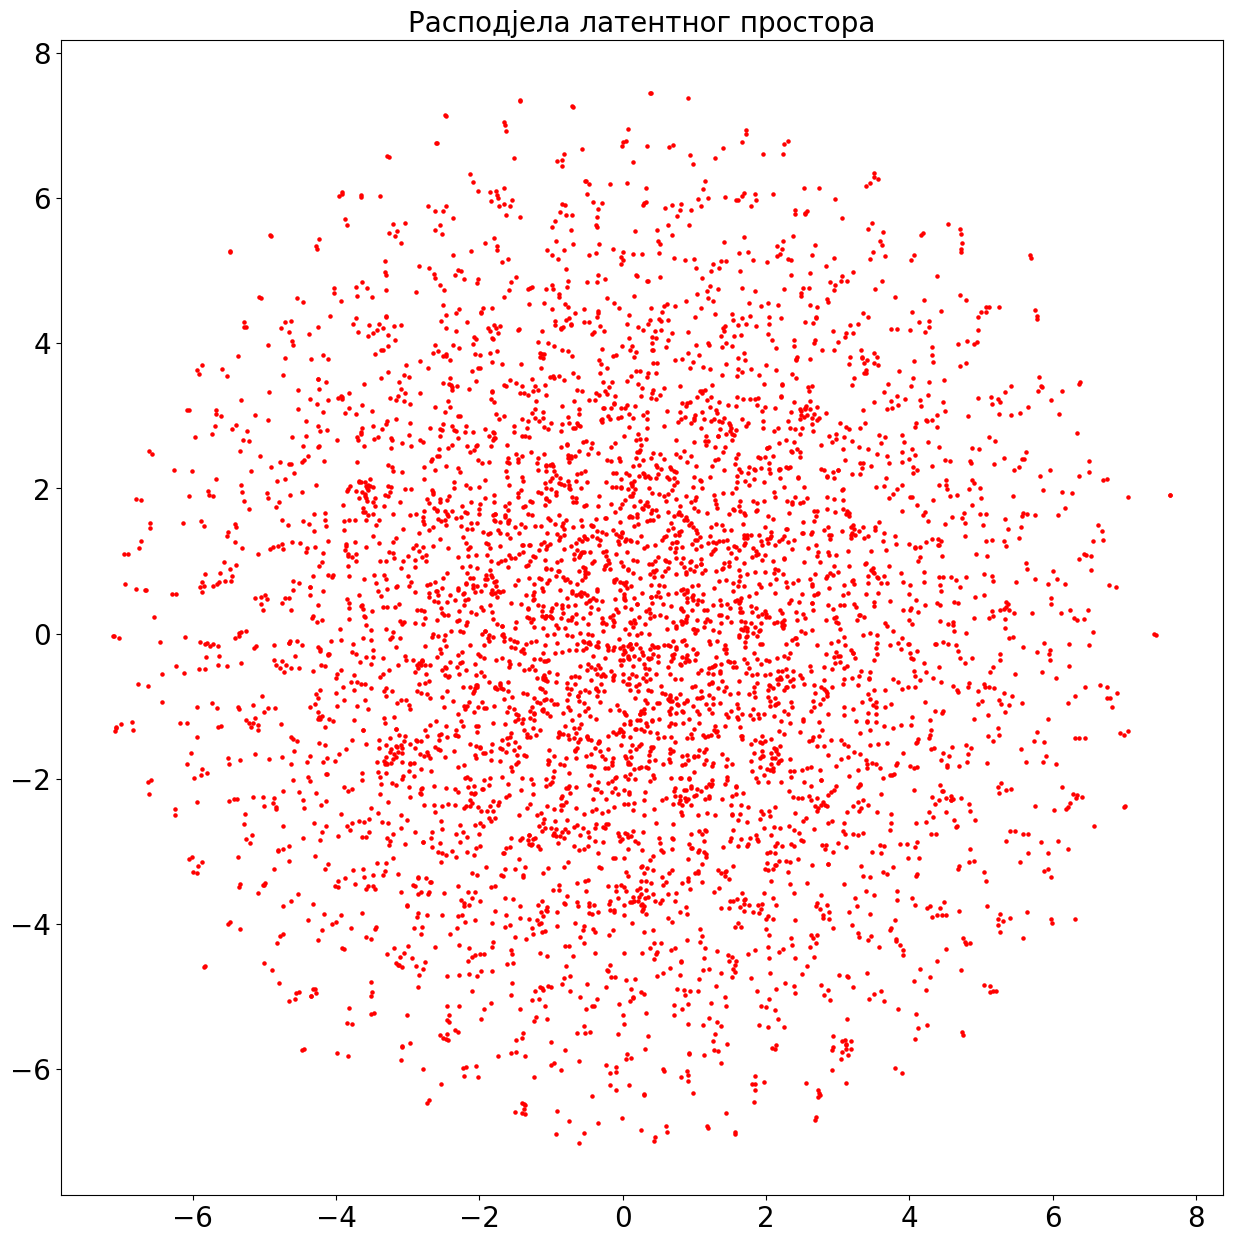

In [19]:
reconstructions = None
mean = None
var = None
for i in norm_dataset:
    m,v = encoder.predict(i)
    rec = dec_input.predict([m,v])
    if reconstructions is None:
        reconstructions = rec
        mean = m
        var = v
    else:
        reconstructions = np.concatenate((reconstructions, rec))
        mean = np.concatenate((mean, m))
        var = np.concatenate((var, v))
    if reconstructions.shape[0] > 5000:
        break

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(reconstructions)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(15, 15))
plt.scatter(X_tsne[:, 0],
            X_tsne[:, 1],
            s=6,
            color="red")
plt.xlabel("", size=20)
plt.ylabel("", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Расподјела латентног простора", size=20)
plt.savefig("/content/drive/MyDrive/vae/Latent-Space-Distribution.png")
plt.show()

In [21]:
import plotly.graph_objects as go
from plotly.io import write_image
from sklearn.manifold import TSNE

def bin_center(bins):
  centers = (bins + (bins[1] - bins[0]) / 2)[:-1]
  return centers

In [37]:
x = X_tsne[:, 0]
y = X_tsne[:, 1]
h, x_edges, y_edges = np.histogram2d(x, y,
                                     bins=50,
                                     density=True)
x_centers = bin_center(x_edges)
y_centers = bin_center(y_edges)

fig= go.Figure(data=[go.Surface(x=x_centers,
                                y=y_centers,
                                z=h)])
fig.show()